In [33]:
import numpy as np
import pandas as pd 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import seaborn as sns

In [2]:
df = pd.read_csv('/home/enno/uni/SS23/thesis/data/hendecads/stretches_w_groups.csv')
df['stretch_ix'] = df['stretch_ix'].apply(lambda x: list(map(int, x.strip('[]').split(','))))

df.head()

,Unnamed: 0,id,seq,stretch_ix,stretch_seq,avg_cc,group_id
0,0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned
1,1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned
2,2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned
3,3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42
4,4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38
...,...,...,...,...,...,...,...
40585,40585,XP_034013580.1,MKLNWLLGILPIVAANFDDWSKADLTQFLEDRNVTVQKGDDLVQLA...,"[667, 798]",kdakksgesfaslasksgawyadafysvasesgesaasqalqtgqk...,0.000553,group_106
40586,40586,GFR06050.1,MSDVYMDDLLTGADDLESGRKLQEQLVSLLRGAGMELHKWSASNPL...,"[578, 680]",eqrsiseeyekirdyfkdlkiklrekftrfgqwvkgkyergleksk...,0.000696,group_9
40587,40587,KAG2190414.1,MSSSILRASIRRNATIANKRFYSAPPPPPYAPNNQGGGNGGLFLGL...,"[65, 170]",gtltkqgevvdqkiqegkqavrdkadeakakyeqskseagqavdqk...,0.000676,unassigned
40588,40588,MBY0528383.1,MRVYCSLLASLLTCATIASQPPPLVFNGGTNSLAPRRILAAEKQET...,"[734, 833]",isaltndknrmvrknavdslgffpwdakaivpllvallsdkdsdla...,0.000714,group_1_1


### Dictionaries and Utils

In [3]:
aa_dict = {'r': '+',
           'h': '+',
           'k': '+',
           'd': '-',
           'e': '-',
           's': 'polar',
           't': 'polar',
           'n': 'polar',
           'q': 'polar',
           'c': 'special',
           'u': 'special',
           'g': 'special',
           'p': 'special',
           'a': 'hydrophobic',
           'v': 'hydrophobic',
           'i': 'hydrophobic',
           'l': 'hydrophobic',
           'm': 'hydrophobic',
           'f': 'hydrophobic',
           'y': 'hydrophobic',
           'w': 'hydrophobic',
           'x': 'padding'}

aa_num_dict = {'r': 0,
               'h': 0,
               'k': 0,
               'd': 1,
               'e': 1,
               's': 2,
               't': 2,
               'n': 2,
               'q': 2,
               'c': 3,
               'u': 3,
               'g': 3,
               'p': 3,
               'a': 4,
               'v': 4,
               'i': 4,
               'l': 4,
               'm': 4,
               'f': 4,
               'y': 4,
               'w': 4,
               'x': 5}

color_dict = {'+': '#00A012',           # green  
              '-': '#D81B60',           # red
              'polar': '#FFC107',       # yellow
              'hydrophobic': '#1E88E5', # blue    
              'special': '#ADADAD',     # grey
              'padding': '#FFFFFF'}     # white 

color_num_dict = {0: '#00A012',           # green
                  1: '#D81B60',           # red
                  2: '#FFC107',           # yellow
                  3: '#1E88E5',           # blue
                  4: '#ADADAD',           # grey
                  5: '#FFFFFF'}           # white

In [4]:
# Letter code and color code for expected hendecad repeat
repeat = ['A', '*', '*', 'D', 'E', '*', '*', 'H', '*', '*', '*']
color_repeat = [color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['hydrophobic'], color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['special']]

### Visual

In [6]:
def plot_seq_pc(seq_id, seq, n_shift=0, save=False):
    seq = seq[n_shift:]
    
    n = len(seq)
    q = n // 11
    r = n % 11

    positions = [repeat[i%11] for i in range(len(seq))]
    colors = [color_dict[aa_dict[aa]] for aa in seq]
    
    # pad last hendecad with padding color
    if n % 11 != 0:
        positions += ['x'] * (11 - r)
        colors += [color_dict['padding']] * (11 - r)
    
    fig, axes = plt.subplots(q+1, 1, figsize=(6, q/3))

    first = True
    for ax in axes:
        
        if first:
            ax.set_title(seq_id) 
            first = False
        
        ax.bar(np.arange(11), np.ones(11), color=colors[:11], edgecolor='black')
        ax.set_yticks([])
        ax.set_xticks([])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        colors = colors[11:]
        positions = positions[11:]

    ax.set_xticks(np.arange(11))
    ax.set_xticklabels(repeat)

    legend_elements = [Patch(facecolor=color_dict[aa], edgecolor='black', label=aa) for aa in color_dict.keys()]
    plt.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.33, q-2))
    
    if save:
        plt.savefig(f'/home/enno/uni/SS23/thesis/seq_analysis/plots/{seq_id}.png', bbox_inches='tight')
        plt.clf()
    else:
        plt.show()

In [ ]:
current_group = 'group_4'
n_samples = 6

tmp_df = df[df['group_id'] == current_group].sample(n_samples)[['id', 'stretch_seq']]

for i, row in tmp_df.iterrows():
    plot_seq_pc(current_group + '_' + row['id'], row['stretch_seq'], save=True)

### RegEx

In [15]:
PID = 'WP_132310275.1'

s1 = df[df['id'] == PID]['stretch_seq'].values[0]
s2 = df[df['id'] == PID]['stretch_seq'].values[1]

In [84]:
def find_repeat(seq, pattern, len_pattern):
    # max_s1 is the maximum number of repeats in one reading frame
    # ! searches patterns in all reading frames

    max_s1 = len(seq) // len_pattern
    return len(re.findall(pattern, seq)), max_s1

n = 10
pattern = r'([avilm].{6}[avilm].{3}){10}'
len_pattern = 11*n

res = []

for i in range(len(df)):
    x, y = find_repeat(df.loc[i, 'stretch_seq'], pattern, len_pattern)
    
    if y == 0:
        res.append(0)
    else:    
        res.append(x/y)

df[f'{n}R'] = res

In [85]:
df

,Unnamed: 0,id,seq,stretch_ix,stretch_seq,avg_cc,group_id,ratio,1R,2R,3R,4R,10R,5R
0,0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned,0.666667,0.833333,0.666667,0.500000,1.000000,0.0,0.000000
1,1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned,0.014706,0.058824,0.000000,0.000000,0.000000,0.0,0.000000
2,2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned,0.555556,0.833333,0.666667,0.500000,1.000000,0.0,1.000000
3,3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42,0.162162,0.666667,0.500000,0.333333,0.000000,0.0,0.000000
4,4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38,0.333333,0.800000,0.714286,0.800000,0.333333,0.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40585,40585,XP_034013580.1,MKLNWLLGILPIVAANFDDWSKADLTQFLEDRNVTVQKGDDLVQLA...,"[667, 798]",kdakksgesfaslasksgawyadafysvasesgesaasqalqtgqk...,0.000553,group_106,0.072581,0.545455,0.200000,0.333333,0.000000,0.0,0.000000
40586,40586,GFR06050.1,MSDVYMDDLLTGADDLESGRKLQEQLVSLLRGAGMELHKWSASNPL...,"[578, 680]",eqrsiseeyekirdyfkdlkiklrekftrfgqwvkgkyergleksk...,0.000696,group_9,0.035294,0.333333,0.000000,0.000000,0.000000,0.0,0.000000
40587,40587,KAG2190414.1,MSSSILRASIRRNATIANKRFYSAPPPPPYAPNNQGGGNGGLFLGL...,"[65, 170]",gtltkqgevvdqkiqegkqavrdkadeakakyeqskseagqavdqk...,0.000676,unassigned,0.333333,0.666667,0.500000,0.000000,0.000000,0.0,0.000000
40588,40588,MBY0528383.1,MRVYCSLLASLLTCATIASQPPPLVFNGGTNSLAPRRILAAEKQET...,"[734, 833]",isaltndknrmvrknavdslgffpwdakaivpllvallsdkdsdla...,0.000714,group_1_1,0.134454,0.777778,0.750000,0.666667,0.500000,0.0,1.000000


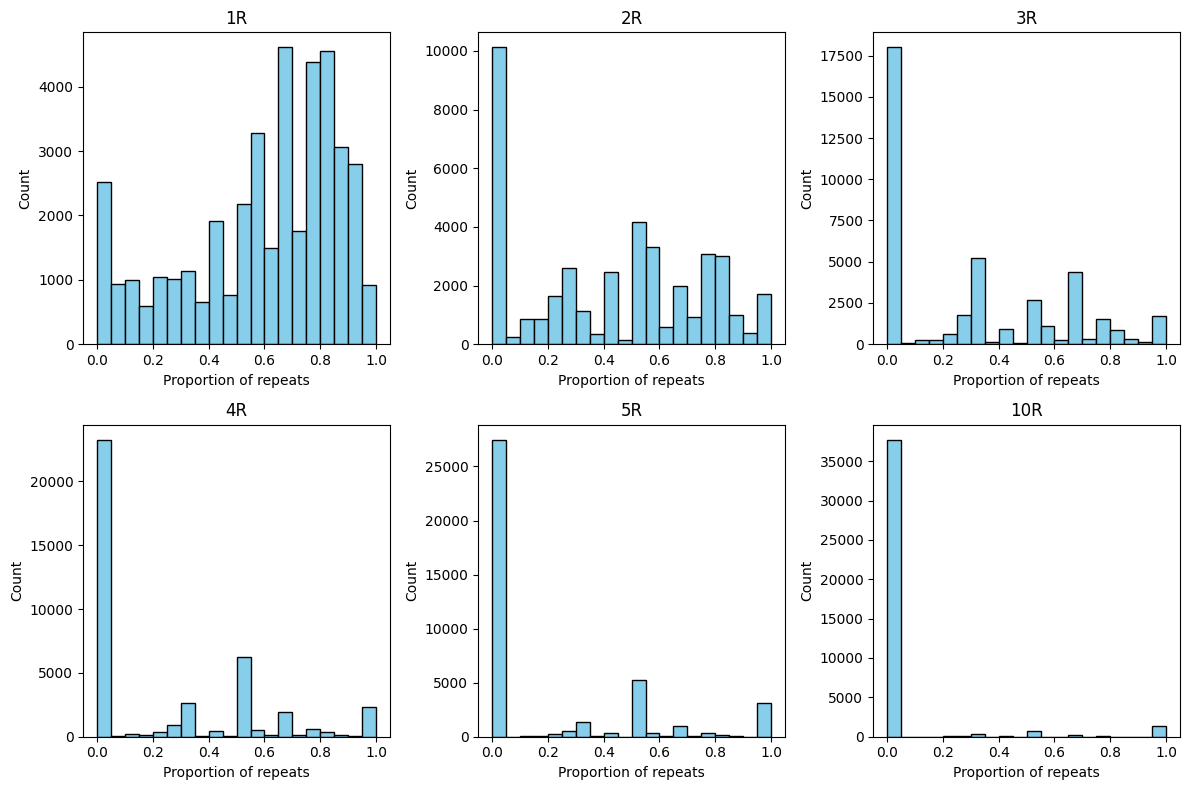

In [89]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

R = ['1', '2', '3', '4', '5', '10']

for i, ax in zip(R, axes.flat):
    ax.hist(df[f'{i}R'], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'{i}R')
    ax.set_xlabel('Proportion of repeats')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


In [51]:
df['ratio'] = res

In [52]:
len(df[df['ratio'] > 0.5])

5188

In [53]:
df[df['ratio'] > 0.5]['group_id'].value_counts()

group_id
unassigned    4499
group_1_1      197
group_1_2      173
group_0        146
group_4         29
group_12        25
group_6         19
group_7         19
group_1_4       17
group_31         7
group_9          6
group_24         6
group_37         6
group_20         5
group_83         4
group_72         4
group_131        3
group_1_0        3
group_3          3
group_95         2
group_19         2
group_1_5        2
group_67         1
group_106        1
group_59         1
group_2          1
group_46         1
group_66         1
group_88         1
group_40         1
group_74         1
group_71         1
group_15         1
Name: count, dtype: int64